In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

## 데이터 로드 및 전처리

In [2]:
df = pd.read_csv('cabbage_merge.csv',encoding='cp949')
# 변수 제거
# df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
df.일시 = pd.to_datetime(df.일시)
#df['dayofweek'] = df['Date'].dt.dayofweek
df.set_index('일시', inplace=True)

In [4]:
df = df.drop(['품목','품종','광역산지','연도','월','일'],axis=1)

In [5]:
df.tail()

,일별 도매가격(원/kg) 평균,일별 거래금액(백만원) 평균,일별 거래량(톤) 합,고랭지배추:면적 (ha),10a당 생산량 (kg),생산량 (톤),2달 평균기온(°C),2달 평균최저기온(°C),2달 평균최고기온(°C),일강수량(mm),2달 평균 풍속(m/s),2달 평균 상대습도(%),2달 평균 합계일조시간(hr)
일시,,,,,,,,,,,,,
2020-11-16,443.0,0.64,1.44,0,0,0,15.267213,11.104918,20.050820,0.727869,2.321311,58.267213,6.542623
2020-11-18,630.0,0.45,0.72,0,0,0,15.119672,10.877049,19.959016,0.727869,2.296721,58.755738,6.503279
2020-11-19,550.0,0.31,0.57,0,0,0,15.104918,10.813115,19.937705,0.854098,2.336066,58.781967,6.362295
2020-11-20,510.0,0.55,1.08,0,0,0,14.926230,10.640984,19.749180,0.854098,2.381967,58.762295,6.349180
2020-11-24,775.0,0.45,0.58,0,0,0,14.278689,9.990164,19.096721,0.475410,2.385246,57.159016,6.309836


In [6]:
# 결측치 확인
df.isnull().sum().sum()

0

In [7]:
# 데이터 프레임 형태 확인
print("전체 데이터 shape: {}".format(df.shape))
print("target feature shape: {}".format(df['일별 도매가격(원/kg) 평균'].shape))

전체 데이터 shape: (665, 13)
target feature shape: (665,)


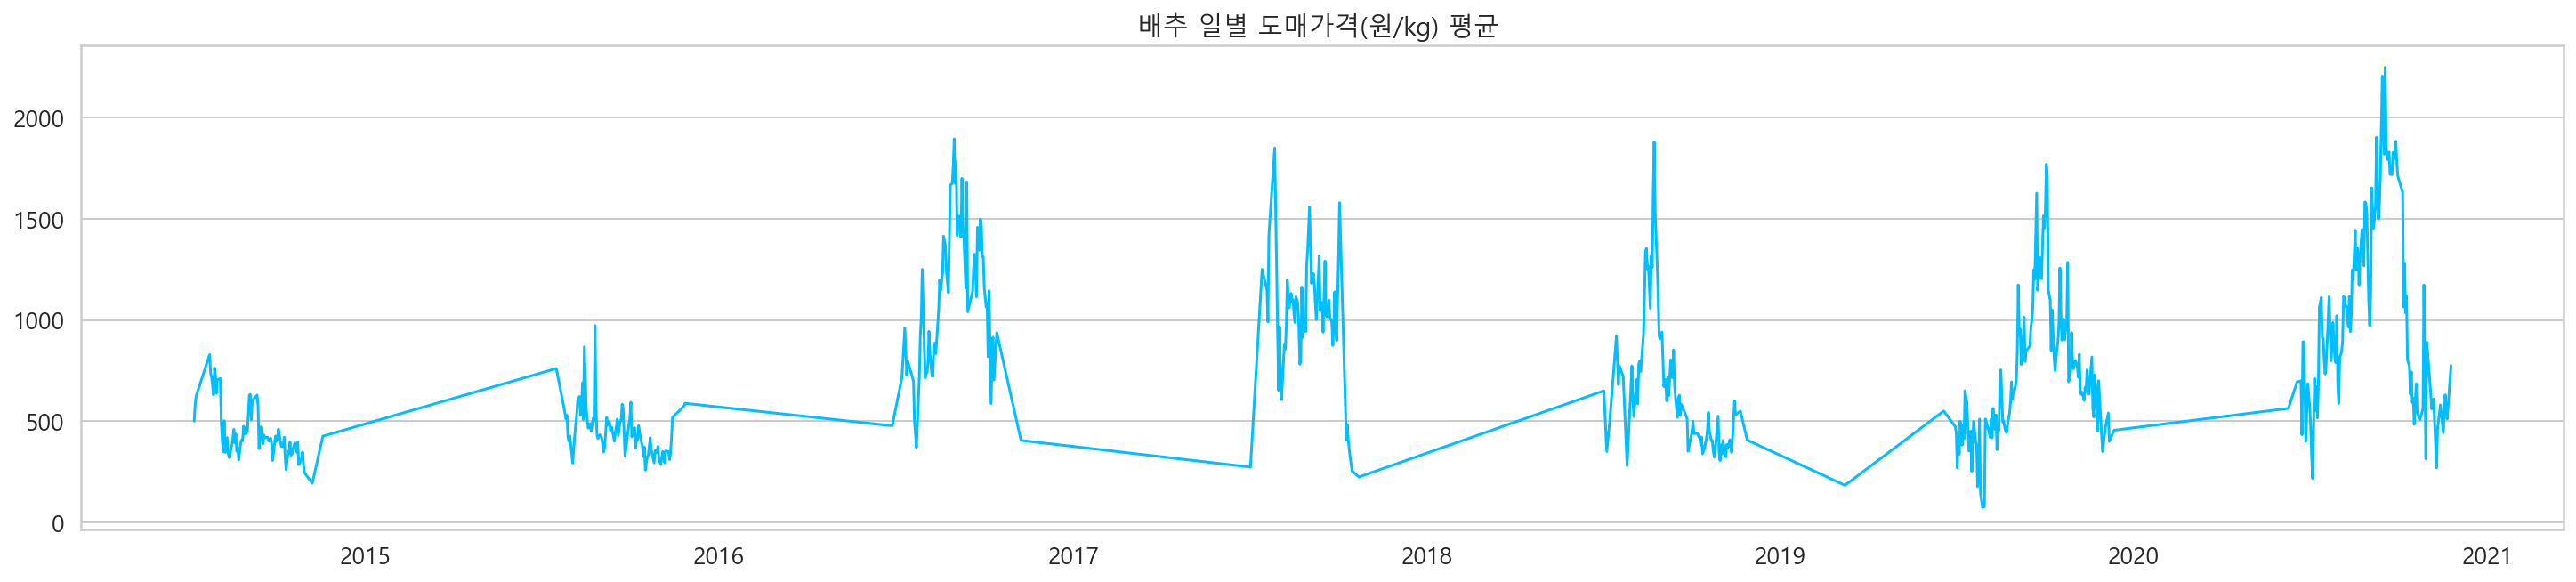

In [8]:
plt.figure(figsize=(25,5))
plt.plot(df['일별 도매가격(원/kg) 평균'])
# plt.xticks(rotation=90)
plt.title("배추 일별 도매가격(원/kg) 평균 ")
plt.grid(axis='x')

In [9]:
X_cols = list(df.columns)
X_cols.remove('일별 도매가격(원/kg) 평균')

In [10]:
test_data_size = 200
# # X변수들과 y변수 구분
X = df[X_cols]
y = df['일별 도매가격(원/kg) 평균']

In [11]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
X = scaler.fit_transform(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
#X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()

# from sklearn.preprocessing import StandardScaler
# dataset = X.values
# std = StandardScaler()
# dataset = std.fit_transform(dataset) 
# y = dataset[:,0]
# x = dataset[:,1:]
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)

In [12]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (465, 12)
test set :  (200, 12)


In [13]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp=array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
        
    return res

In [14]:
# 시퀀스 길이
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)

In [15]:
# numpy -> tensor 변환
X_train = torch.from_numpy(np.array(X_train).astype(np.float32))
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [16]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([465, 1, 12])
X_test : torch.Size([200, 1, 12])
y_train : torch.Size([465, 1])
y_test : torch.Size([200, 1])


## 모델 생성

In [17]:
# Model Class 생성

class CabbagePredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CabbagePredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.1
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

In [18]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=500, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [19]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=64
n_layers=4
lr=1e-4
num_epochs=300

In [20]:
# Training Model
model = CabbagePredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.1443 test loss: 0.2691
Epoch 10 train loss: 0.1252 test loss: 0.242
Epoch 20 train loss: 0.1077 test loss: 0.2163
Epoch 30 train loss: 0.0906 test loss: 0.1904
Epoch 40 train loss: 0.073 test loss: 0.1625
Epoch 50 train loss: 0.0543 test loss: 0.1306
Epoch 60 train loss: 0.0364 test loss: 0.0934
Epoch 70 train loss: 0.0286 test loss: 0.0594
Epoch 80 train loss: 0.0294 test loss: 0.0523
Epoch 90 train loss: 0.0283 test loss: 0.061
Epoch 100 train loss: 0.0283 test loss: 0.0628
Epoch 110 train loss: 0.028 test loss: 0.059
Epoch 120 train loss: 0.0278 test loss: 0.057
Epoch 130 train loss: 0.0276 test loss: 0.0575
Epoch 140 train loss: 0.0273 test loss: 0.0572
Epoch 150 train loss: 0.027 test loss: 0.0558
Epoch 160 train loss: 0.0267 test loss: 0.0548
Epoch 170 train loss: 0.0263 test loss: 0.0538
Epoch 180 train loss: 0.0258 test loss: 0.0522
Epoch 190 train loss: 0.0252 test loss: 0.0503
Epoch 200 train loss: 0.0245 test loss: 0.0479
Epoch 210 train loss: 0.0235 te

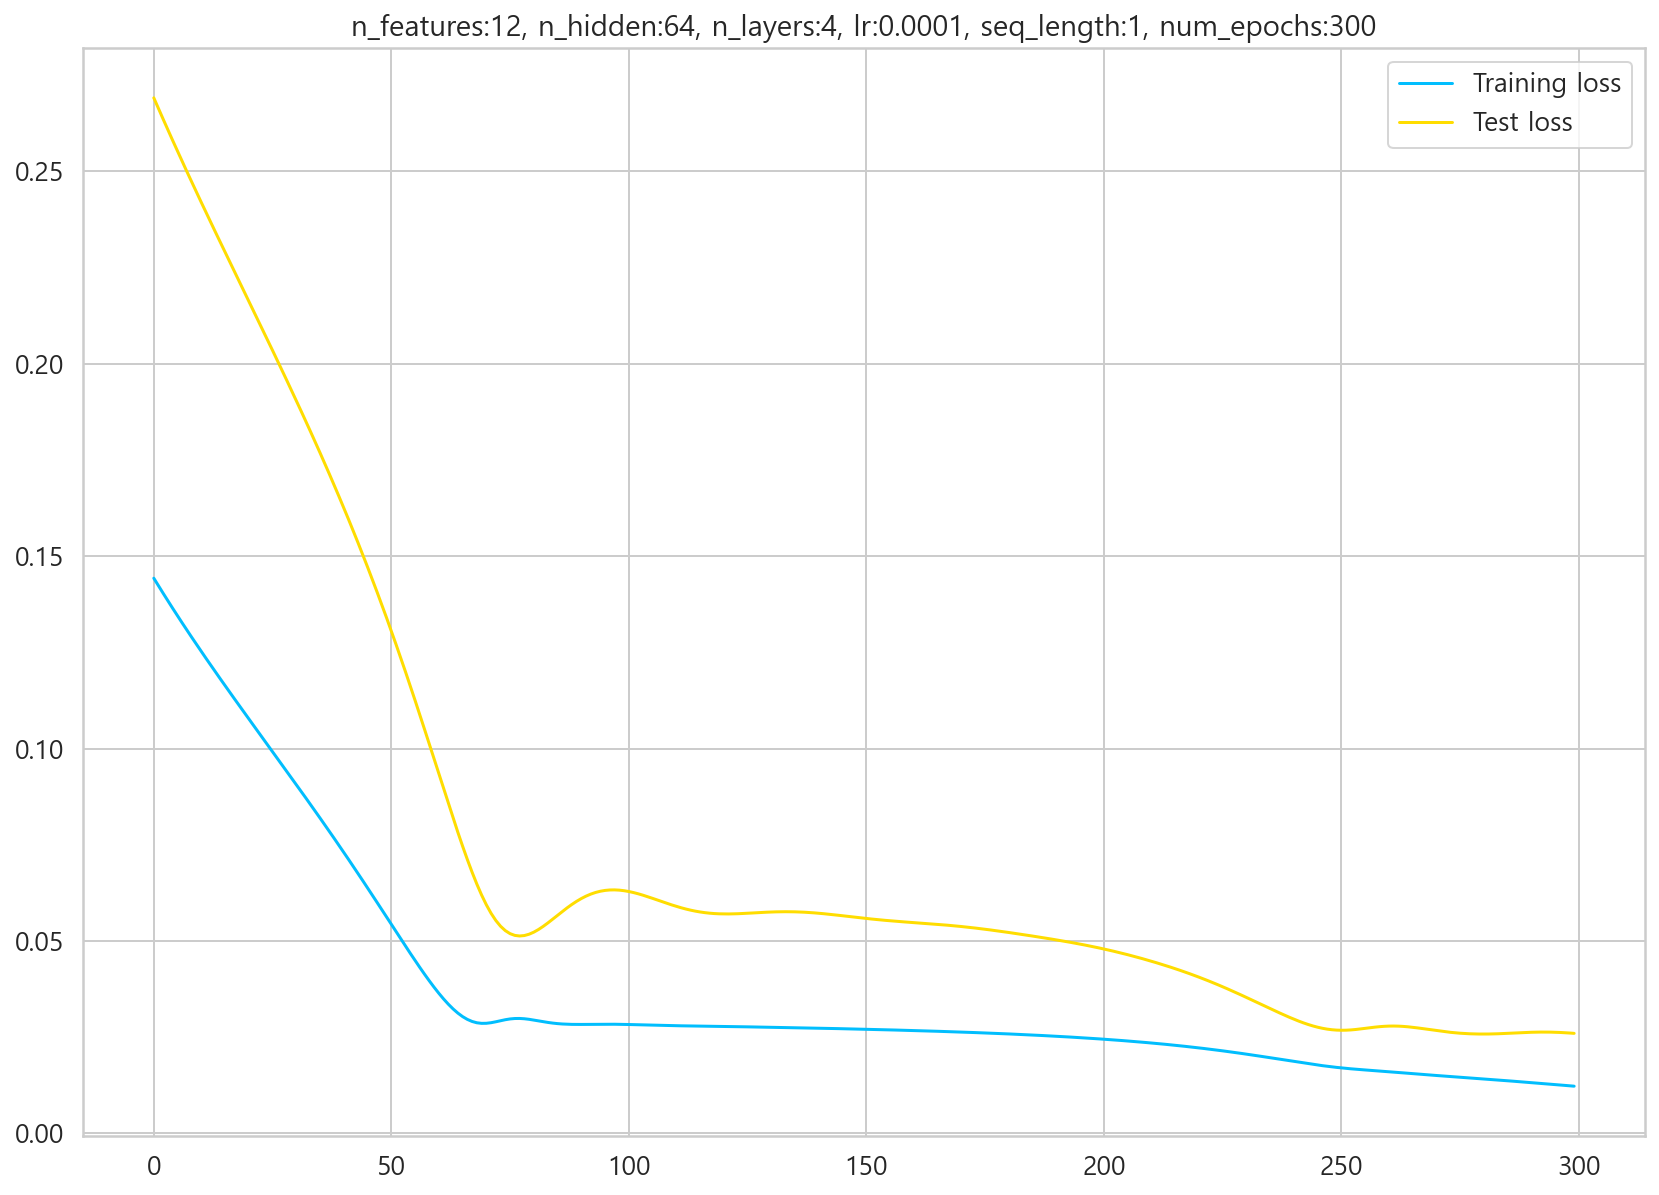

In [21]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

## 케이스 예측해보기

In [22]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [23]:
preds

[0.24343042075634003,
 0.23945163190364838,
 0.23987822234630585,
 0.24385927617549896,
 0.2501905858516693,
 0.25765979290008545,
 0.2651906907558441,
 0.2721109688282013,
 0.2777297794818878,
 0.2820424735546112,
 0.28520217537879944,
 0.2871282398700714,
 0.28766098618507385,
 0.28689640760421753,
 0.2849726378917694,
 0.2818661034107208,
 0.2776041328907013,
 0.2726348340511322,
 0.26736998558044434,
 0.26214224100112915,
 0.2572464048862457,
 0.25298890471458435,
 0.24943925440311432,
 0.24687720835208893,
 0.24525244534015656,
 0.2443798929452896,
 0.24405847489833832,
 0.24417908489704132,
 0.2446562498807907,
 0.24545247852802277,
 0.2462654560804367,
 0.24697501957416534,
 0.24785150587558746,
 0.2491285651922226,
 0.2509847581386566,
 0.253418892621994,
 0.2563716173171997,
 0.25973230600357056,
 0.26337218284606934,
 0.26710960268974304,
 0.270734041929245,
 0.27413690090179443,
 0.2771017253398895,
 0.2794339954853058,
 0.28107860684394836,
 0.282003790140152,
 0.2822321653

In [24]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [25]:
pred_values

array([[ 604.00294316],
       [ 595.35656689],
       [ 596.28359811],
       [ 604.93489644],
       [ 618.69357723],
       [ 634.92504287],
       [ 651.2905699 ],
       [ 666.3291483 ],
       [ 678.53948489],
       [ 687.91147649],
       [ 694.77788028],
       [ 698.96344501],
       [ 700.12116543],
       [ 698.45964623],
       [ 694.27906831],
       [ 687.52820341],
       [ 678.26644006],
       [ 667.46756906],
       [ 656.02643394],
       [ 644.66592994],
       [ 634.02670209],
       [ 624.77465333],
       [ 617.0608456 ],
       [ 611.49321811],
       [ 607.96241694],
       [ 606.06625793],
       [ 605.3677787 ],
       [ 605.62987842],
       [ 606.66681406],
       [ 608.39711259],
       [ 610.16380845],
       [ 611.7057734 ],
       [ 613.61048125],
       [ 616.38568139],
       [ 620.41940704],
       [ 625.70906764],
       [ 632.12568578],
       [ 639.42885767],
       [ 647.33873827],
       [ 655.46059129],
       [ 663.33692416],
       [ 670.731

In [26]:
pred_values_ceiled  = list(pred_values.flatten())

In [27]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [28]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [29]:
score_table

,True,Pred
0,487.999985,604.002943
1,539.428587,595.356567
2,593.230755,596.283598
3,694.099996,604.934896
4,606.866676,618.693577
...,...,...
195,443.000016,733.677442
196,630.000003,703.713622
197,550.000007,674.675279
198,510.000009,647.158694


In [30]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [31]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 118247.70097006527, RMSE : 343.87163443655146, SCORE : 89.5795782302402


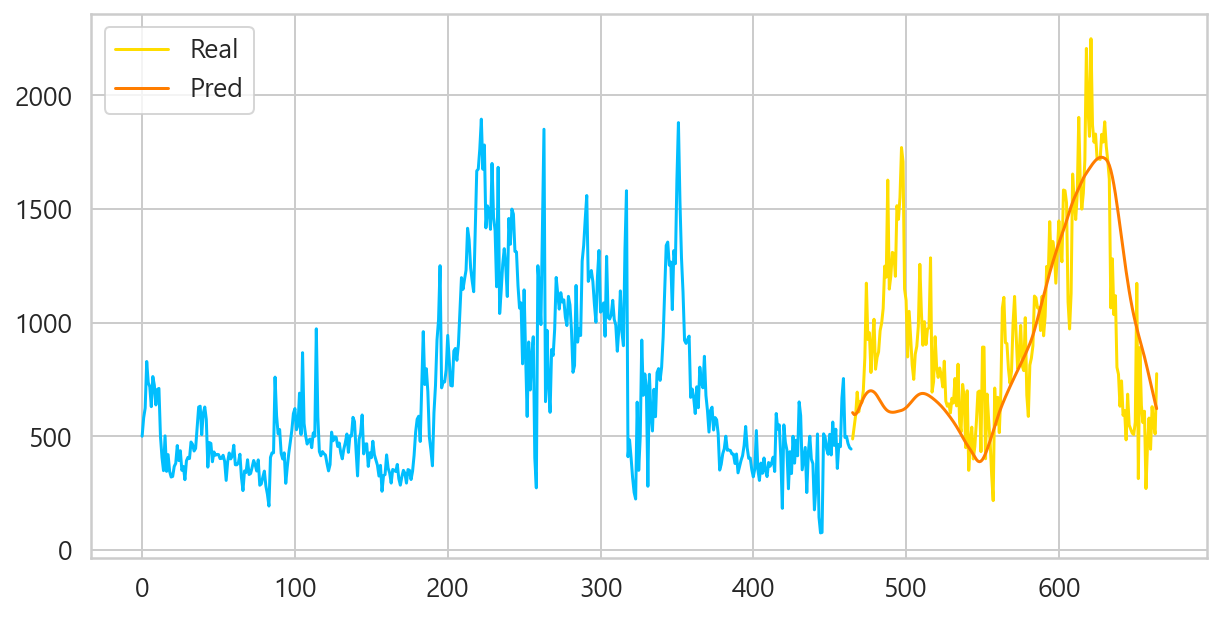

In [32]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

## 전체 데이터를 사용하여 미래 예측

In [33]:
# X변수들과 y변수 구분
X_all = df[X_cols]
y_all = df['일별 도매가격(원/kg) 평균']

In [34]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit_transform(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
# X_all = Xscaler.transform(X_all)
y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()


In [35]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (665, 12)
y_all :  (665,)


In [36]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [37]:
#X_all

In [38]:
DAYS_TO_PREDICT = 30

# with torch.no_grad():
#     test_seq = X_all[:1]
#     preds = []
#     for _ in range(DAYS_TO_PREDICT):
#         y_test_pred = model(test_seq)
#         pred = torch.flatten(y_test_pred).item()
#         preds.append(pred)
#         new_seq = test_seq.numpy().flatten()
#         new_seq = np.append(new_seq, [pred])
#         new_seq = new_seq[1:]
#         test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        
# with torch.no_grad():
    
#     test_seq = X_all[:-1]
#     preds = []
#     for i in range(DAYS_TO_PREDICT):
#         test_seq = X_all[:1]
#         y_test_pred = model(test_seq)
#         pred = torch.flatten(y_test_pred).item()
#         preds.append(pred)
#         new_seq = test_seq.numpy().flatten()
#         new_seq = np.append(new_seq, pred)
#         new_seq = new_seq[1:]
#         test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

with torch.no_grad():
    
    preds = []
    for i in range(DAYS_TO_PREDICT):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [39]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [40]:
# 예측값 반올림
import math

pred_values_ceiled = list(pred_values.flatten())
predicted_cases=pred_values_ceiled
predicted_cases

[603.0695003119396,
 594.4421646445629,
 595.3848687400974,
 604.04134818619,
 617.7970174482971,
 634.0229457763509,
 650.3863355940153,
 665.4306132230397,
 677.6575293816093,
 687.0578875884403,
 693.963408809274,
 698.1978055648548,
 699.4120649140699,
 697.8123305183708,
 693.6966460880933,
 687.0114518343528,
 677.8141933831961,
 667.0770424286371,
 655.693417698204,
 644.3853077366217,
 633.7928394523997,
 624.58185104327,
 616.9033396649583,
 611.3655683612441,
 607.8598956014694,
 605.9845258230694,
 605.3030147487832,
 605.5790387152003,
 606.6271785257342,
 608.3662849476485]

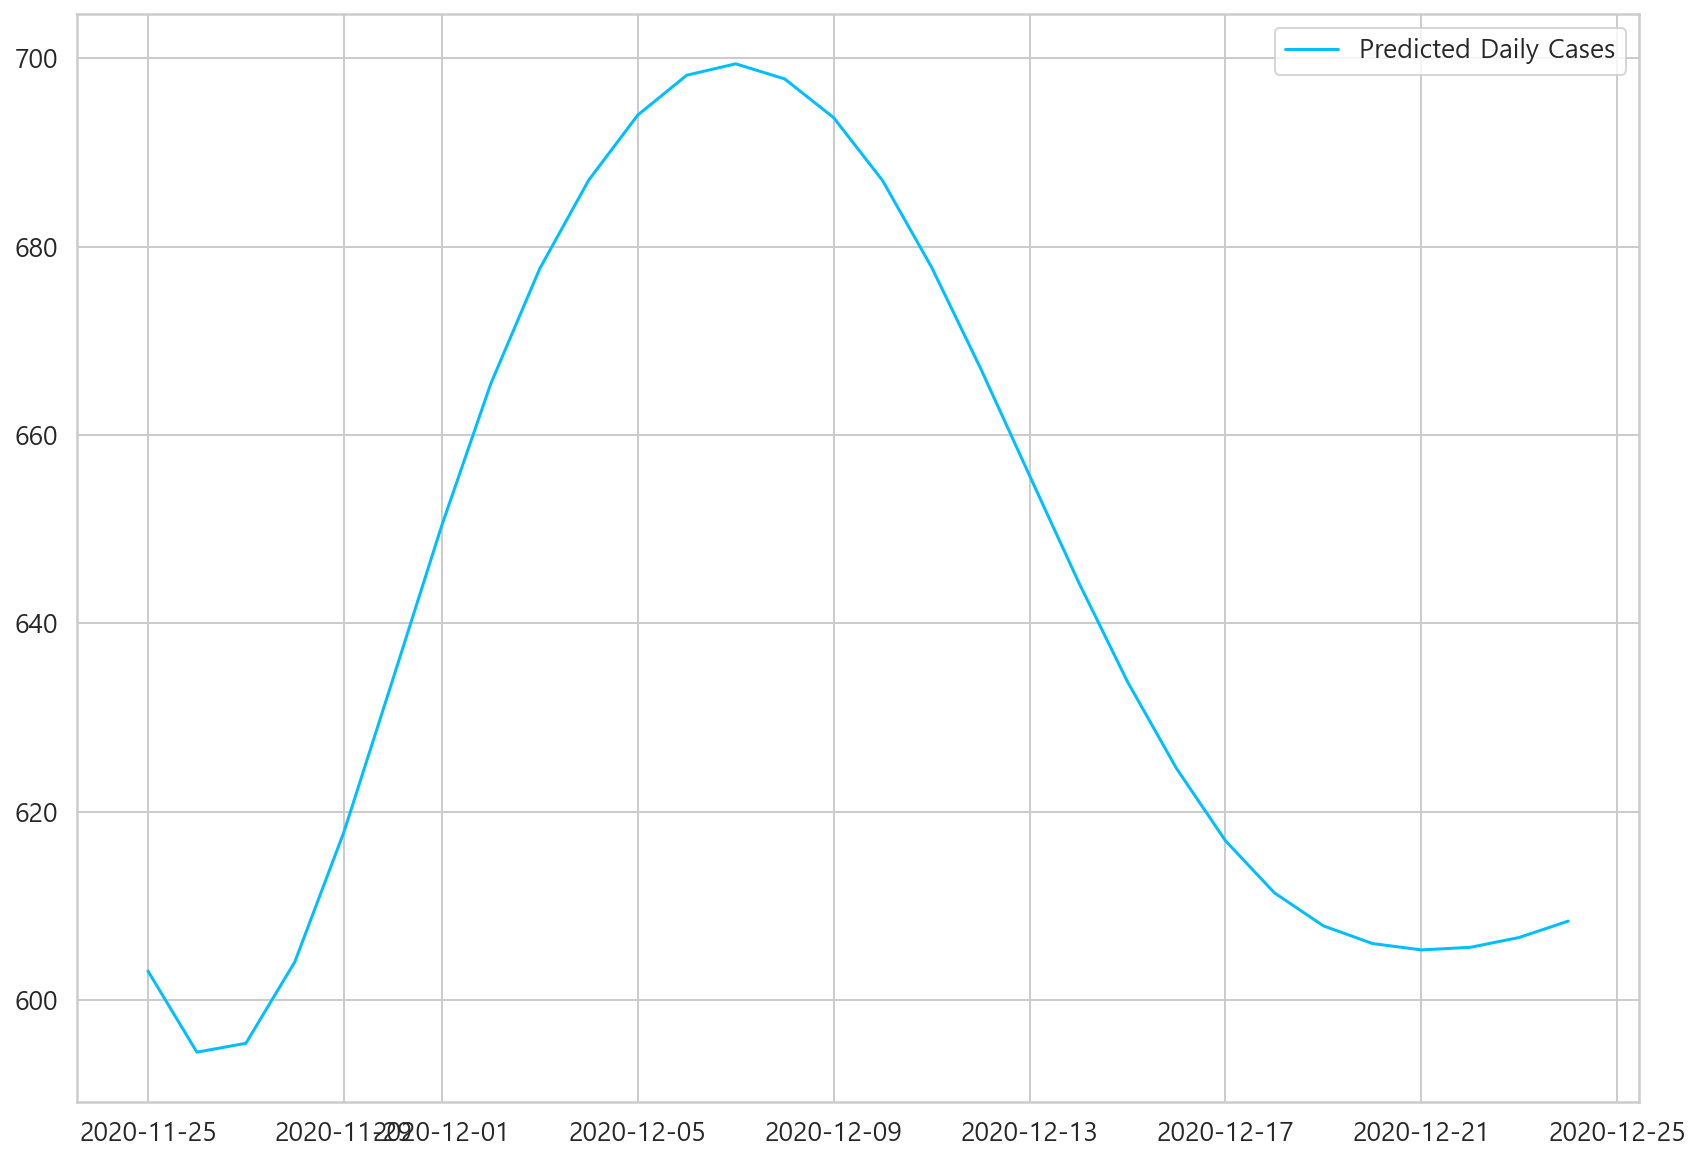

In [41]:

predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [42]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [43]:
preds_

,0
2020-11-25,603.069500
2020-11-26,594.442165
2020-11-27,595.384869
2020-11-28,604.041348
2020-11-29,617.797017
2020-11-30,634.022946
2020-12-01,650.386336
2020-12-02,665.430613
2020-12-03,677.657529
2020-12-04,687.057888


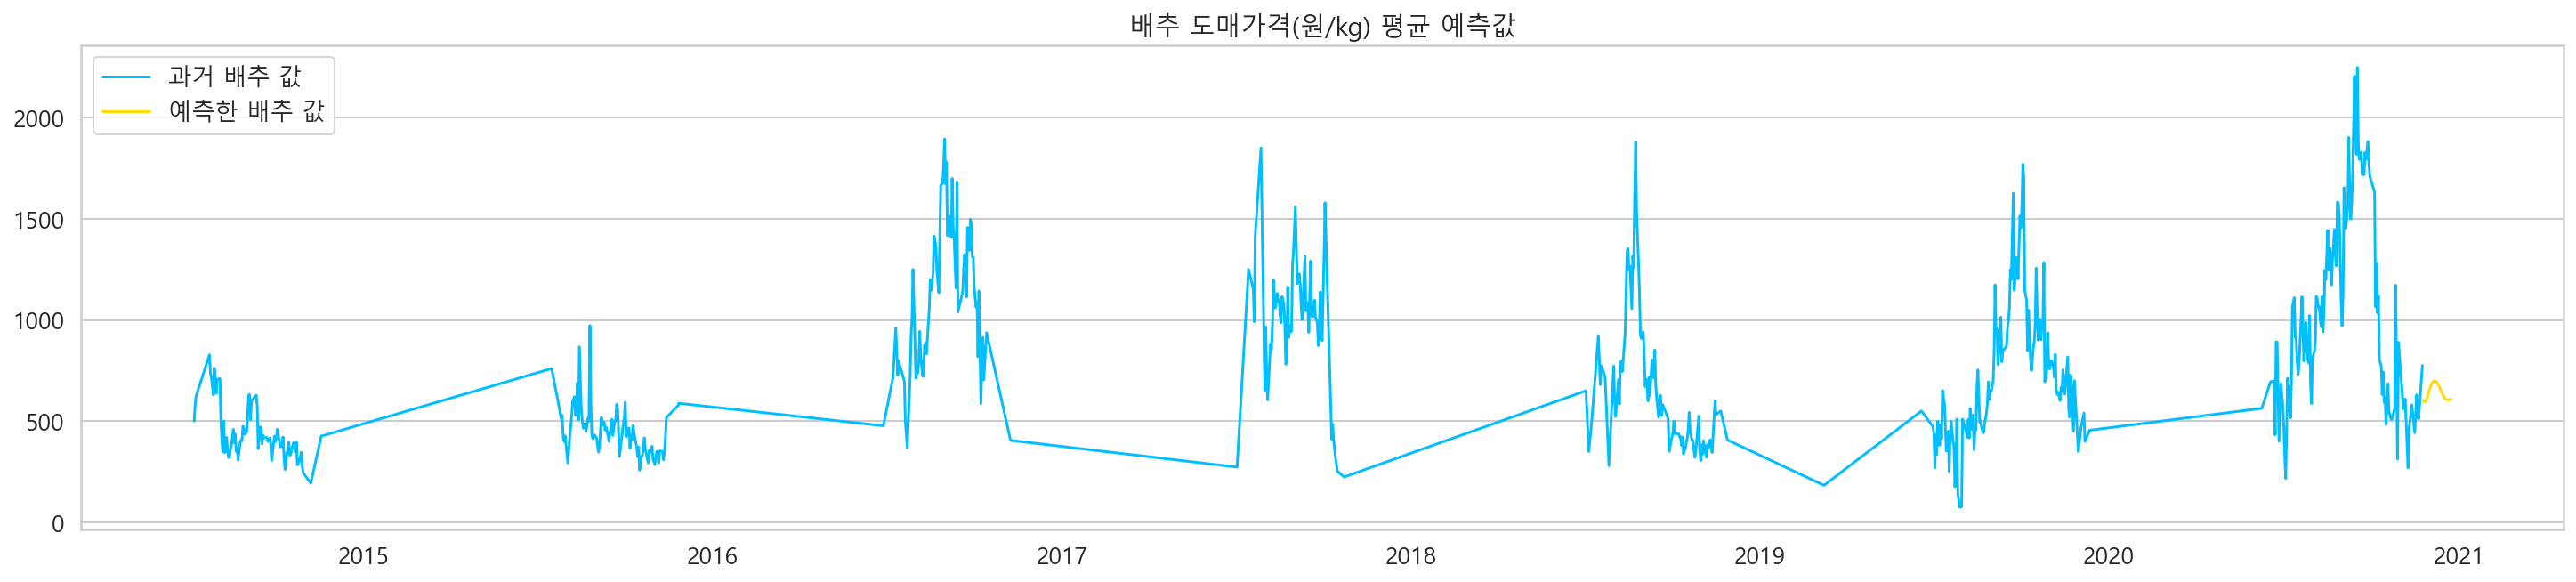

In [44]:
plt.figure(figsize=(25,5))
plt.plot(df['일별 도매가격(원/kg) 평균'].astype(int), label='과거 배추 값')
plt.plot(preds_, label='예측한 배추 값')
# plt.xticks(rotation=90)
plt.title("배추 도매가격(원/kg) 평균 예측값")
plt.grid(axis='x')
plt.legend();